# Bayesian optimization of a SOI vertical grating coupler 

Grating couplers are photonic devices that couple light efficiently between optical fibers and integrated photonic waveguides. They work by diffracting light incident from above into the plane of the chip, enabling vertical fiber-to-chip coupling—a key functionality for scalable photonic integrated circuits. Vertical grating couplers are widely used because they simplify packaging and alignment compared to edge coupling, and can be designed with high efficiency for target wavelengths, such as the telecom band around 1.55 μm.

This notebook demonstrates the design optimization of a vertical grating coupler using the Bayesian optimizer from Tidy3D's `design` plugin. The optimized design achieves a < 2dB coupling efficiency. The design is based on the work `T. Watanabe, M. Ayata, U. Koch, Y. Fedoryshyn and J. Leuthold, "Perpendicular Grating Coupler Based on a Blazed Antiback-Reflection Structure," in Journal of Lightwave Technology, vol. 35, no. 21, pp. 4663-4669, 1 Nov.1, 2017.` [DOI: 10.1109/JLT.2017.2755673](https://ieeexplore.ieee.org/document/8048498).

<center><img src="img/vertical_grating_coupler.png" alt="schematic"  width="500"/></center>

In [1]:
# Standard library imports
import matplotlib.pyplot as plt
import numpy as np

# Tidy3D imports
import tidy3d as td
import tidy3d.plugins.design as tdd
import tidy3d.web as web

## Simulation Setup

We define the simulation parameters, including the wavelength range, fixed geometric parameters, and the materials (silicon and silicon oxide).

In [2]:
# Define frequency and wavelength range
lda0 = 1.55  # Central wavelength
freq0 = td.C_0 / lda0  # Central frequency
ldas = np.linspace(1.5, 1.6, 101)  # Wavelength range
freqs = td.C_0 / ldas  # Frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # Frequency width of the source

In [3]:
# Geometric parameters
h_si = 0.22  # Silicon thickness
h_etch = 0.07  # Etch depth
h_box = 3  # Buried oxide thickness
h_clad = 1.5  # Cladding thickness
n = 20  # Number of grating periods
mfd = 10.4  # Mode field diameter
ly = 15  # Grating size in y

# Materials
n_si = 3.45
mat_si = td.Medium(permittivity=n_si**2)

n_sio2 = 1.45
mat_sio2 = td.Medium(permittivity=n_sio2**2)

The grating coupler geometry is parameterized by the thickness and width of the grating teeth (`t1`, `t2`, `w1`, `w2`, `w3`). The `make_grating` function constructs the grating geometry, and `make_sim_2d` creates the full Tidy3D simulation, including the waveguide, substrate, source, and monitors. We will start our optimization in 2D since it's much faster and cheaper. Then we will verify the optimal design with the full 3D simulation.

<center><img src="img/grating_schematic.png" alt="schematic"  width="400"/></center>

In [4]:
def make_grating(t1, t2, w1, w2, w3):
    """Constructs the grating geometry based on parameters."""
    p = t1 + t2 + w1 + w2 + w3  # Grating period
    grating = 0
    for i in range(n):
        # First tooth section
        grating += td.Box.from_bounds(
            rmin=(i * p + t1, -ly / 2, 0), rmax=(i * p + t1 + w1, ly / 2, h_si)
        )

        # Etched section
        grating += td.Box.from_bounds(
            rmin=(i * p + t1 + w1 + t2, -ly / 2, 0),
            rmax=(i * p + t1 + w1 + t2 + w2, ly / 2, h_si - h_etch),
        )

        # Second tooth section
        grating += td.Box.from_bounds(
            rmin=(i * p + t1 + w1 + t2 + w2, -ly / 2, 0),
            rmax=(i * p + t1 + w1 + t2 + w2 + w3, ly / 2, h_si),
        )

    return td.Structure(geometry=grating, medium=mat_si)

In [5]:
def make_sim_2d(t1, t2, w1, w2, w3):
    """Creates the Tidy3D simulation."""
    grating = make_grating(t1, t2, w1, w2, w3)

    p = t1 + t2 + w1 + w2 + w3  # Grating period
    lx = p * n  # Grating size in x
    inf_eff = 1e3  # effective infinity

    # Waveguide
    waveguide = td.Structure(
        geometry=td.Box.from_bounds(rmin=(-inf_eff, -ly / 2, 0), rmax=(0, ly / 2, h_si)),
        medium=mat_si,
    )

    # Cladding and buried oxide
    box_clad = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-inf_eff, -inf_eff, -h_box), rmax=(inf_eff, inf_eff, h_clad + h_si)
        ),
        medium=mat_sio2,
    )

    # Substrate
    substrate = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-inf_eff, -inf_eff, -h_box - inf_eff), rmax=(inf_eff, inf_eff, -h_box)
        ),
        medium=mat_si,
    )

    # Gaussian beam source
    gaussian_beam = td.GaussianBeam(
        center=(lx / 2, 0, h_clad + lda0 / 2),
        size=(2 * mfd, 2 * mfd, 0),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        pol_angle=np.pi / 2,
        angle_theta=0,
        angle_phi=0,
        direction="-",
        waist_radius=mfd / 2,
        waist_distance=0,
    )

    # Mode monitor
    mode_monitor = td.ModeMonitor(
        center=(-lda0 / 2, 0, h_si / 2),
        size=(0, 1.5 * ly, 5 * h_si),
        freqs=freqs,
        mode_spec=td.ModeSpec(num_modes=1, target_neff=n_si),
        name="mode",
    )

    # Simulation domain box
    sim_box = td.Box.from_bounds(
        rmin=(-0.6 * lda0, 0, -h_box - 0.6 * lda0),
        rmax=(lx + 0.6 * lda0, 0, h_clad + h_si + 0.6 * lda0),
    )

    # Define the simulation
    sim = td.Simulation(
        center=sim_box.center,
        size=sim_box.size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20),
        run_time=1e-11,
        structures=[substrate, box_clad, grating, waveguide],
        sources=[gaussian_beam],
        monitors=[mode_monitor],
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.pml(),
            y=td.Boundary.periodic(),  # set the boundary to periodic in y since it's a 2D simulation
            z=td.Boundary.pml(),
        ),
    )
    return sim

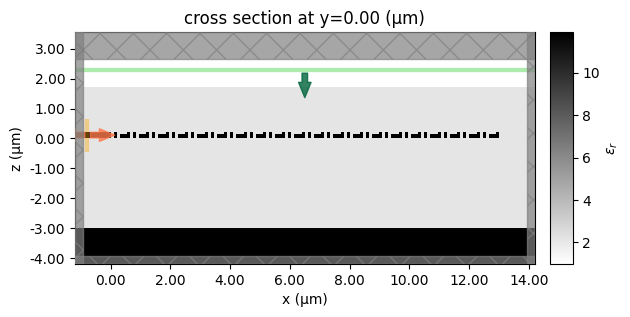

In [6]:
# Create a simulation instance with some arbitrary parameters
sim = make_sim_2d(t1=0.1, t2=0.1, w1=0.1, w2=0.25, w3=0.1)

# Visualize the permittivity distribution
sim.plot_eps(y=0)
plt.show()

## Optimization

Bayesian optimization is a powerful strategy for optimizing expensive-to-evaluate functions, using a probabilistic model to efficiently explore the parameter space and identify optimal solutions with fewer simulations. 

To optimize the grating design for maximal coupling efficiency at 1550 nm, we configure the Bayesian optimization using [MethodBayOpt](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.design.MethodBayOpt.html#tidy3d.plugins.design.MethodBayOpt).

We define the design space for the grating parameters and specify the objective function `compute_transmission`, which calculates the transmission efficiency based on the mode monitor data.

In [7]:
def compute_transmission(sim_data):
    """Calculates the coupling efficiency from the simulation data."""
    # Extract mode amplitude data at 1550 nm
    T = np.abs(sim_data["mode"].amps.sel(mode_index=0, f=freq0, direction="-").values) ** 2
    # Return coupling efficiency in dB
    return 10 * np.log10(T)

To ensure fabrication constraint, we limit the minimal feature size to 50 nm. All design parameters have a range from 50 nm to 250 nm. 

After running the optimization, we achieved a design with sub 2dB coupling efficiency.

In [8]:
# Define optimization method (Bayesian optimization)
method = tdd.MethodBayOpt(
    initial_iter=50,
    n_iter=150,
    acq_func="ucb",
    kappa=1,
    seed=4,
)

span = (0.05, 0.25)  # Parameter value range

# Define optimization parameters
parameters = [
    tdd.ParameterFloat(name="t1", span=span),
    tdd.ParameterFloat(name="t2", span=span),
    tdd.ParameterFloat(name="w1", span=span),
    tdd.ParameterFloat(name="w2", span=span),
    tdd.ParameterFloat(name="w3", span=span),
]

# Define a design space
design_space = tdd.DesignSpace(
    method=method, parameters=parameters, task_name="bay_opt", path_dir="./data"
)

# Run the design optimization
results = design_space.run(make_sim_2d, compute_transmission, verbose=True)

22:32:15 Eastern Standard Time Running 50 Simulations

22:33:46 Eastern Standard Time Best Fit from Initial Solutions: -7.691          
                               

22:33:47 Eastern Standard Time Running 1 Simulations

22:33:52 Eastern Standard Time Running 1 Simulations

22:33:58 Eastern Standard Time Running 1 Simulations

22:34:03 Eastern Standard Time Running 1 Simulations

22:34:09 Eastern Standard Time Running 1 Simulations

22:34:13 Eastern Standard Time Latest Best Fit on Iter 4: -7.068                
                               

22:34:15 Eastern Standard Time Running 1 Simulations

22:34:21 Eastern Standard Time Running 1 Simulations

22:34:25 Eastern Standard Time Latest Best Fit on Iter 6: -6.926                
                               

22:34:26 Eastern Standard Time Running 1 Simulations

22:34:32 Eastern Standard Time Running 1 Simulations

22:34:38 Eastern Standard Time Running 1 Simulations

22:34:42 Eastern Standard Time Latest Best Fit on Iter 9: -3.59                 
                               

22:34:44 Eastern Standard Time Running 1 Simulations

22:34:48 Eastern Standard Time Latest Best Fit on Iter 10: -2.235               
                               

22:34:49 Eastern Standard Time Running 1 Simulations

22:34:55 Eastern Standard Time Running 1 Simulations

22:35:01 Eastern Standard Time Running 1 Simulations

22:35:08 Eastern Standard Time Running 1 Simulations

22:35:14 Eastern Standard Time Running 1 Simulations

22:35:21 Eastern Standard Time Running 1 Simulations

22:35:27 Eastern Standard Time Running 1 Simulations

22:35:35 Eastern Standard Time Running 1 Simulations

22:35:42 Eastern Standard Time Running 1 Simulations

22:35:49 Eastern Standard Time Running 1 Simulations

22:35:56 Eastern Standard Time Running 1 Simulations

22:36:02 Eastern Standard Time Running 1 Simulations

22:36:10 Eastern Standard Time Running 1 Simulations

22:36:17 Eastern Standard Time Running 1 Simulations

22:36:24 Eastern Standard Time Running 1 Simulations

22:36:29 Eastern Standard Time Latest Best Fit on Iter 25: -2.145               
                               

22:36:32 Eastern Standard Time Running 1 Simulations

22:36:40 Eastern Standard Time Running 1 Simulations

22:36:47 Eastern Standard Time Running 1 Simulations

22:36:55 Eastern Standard Time Running 1 Simulations

22:37:01 Eastern Standard Time Running 1 Simulations

22:37:08 Eastern Standard Time Running 1 Simulations

22:37:16 Eastern Standard Time Running 1 Simulations

22:37:24 Eastern Standard Time Running 1 Simulations

22:37:31 Eastern Standard Time Running 1 Simulations

22:37:39 Eastern Standard Time Running 1 Simulations

22:37:47 Eastern Standard Time Running 1 Simulations

22:37:54 Eastern Standard Time Running 1 Simulations

22:38:02 Eastern Standard Time Running 1 Simulations

22:38:10 Eastern Standard Time Running 1 Simulations

22:38:18 Eastern Standard Time Running 1 Simulations

22:38:25 Eastern Standard Time Running 1 Simulations

22:38:33 Eastern Standard Time Running 1 Simulations

22:38:41 Eastern Standard Time Running 1 Simulations

22:38:48 Eastern Standard Time Running 1 Simulations

22:38:55 Eastern Standard Time Running 1 Simulations

22:39:03 Eastern Standard Time Running 1 Simulations

22:39:11 Eastern Standard Time Running 1 Simulations

22:39:19 Eastern Standard Time Running 1 Simulations

22:39:26 Eastern Standard Time Running 1 Simulations

22:39:34 Eastern Standard Time Running 1 Simulations

22:39:42 Eastern Standard Time Running 1 Simulations

22:39:50 Eastern Standard Time Running 1 Simulations

22:39:58 Eastern Standard Time Running 1 Simulations

22:40:06 Eastern Standard Time Running 1 Simulations

22:40:13 Eastern Standard Time Running 1 Simulations

22:40:22 Eastern Standard Time Running 1 Simulations

22:40:30 Eastern Standard Time Running 1 Simulations

22:40:38 Eastern Standard Time Running 1 Simulations

22:40:45 Eastern Standard Time Running 1 Simulations

22:40:53 Eastern Standard Time Running 1 Simulations

22:40:57 Eastern Standard Time Latest Best Fit on Iter 60: -1.962               
                               

22:41:02 Eastern Standard Time Running 1 Simulations

22:41:09 Eastern Standard Time Running 1 Simulations

22:41:16 Eastern Standard Time Running 1 Simulations

22:41:24 Eastern Standard Time Running 1 Simulations

22:41:32 Eastern Standard Time Running 1 Simulations

22:41:40 Eastern Standard Time Running 1 Simulations

22:41:48 Eastern Standard Time Running 1 Simulations

22:41:55 Eastern Standard Time Running 1 Simulations

22:41:59 Eastern Standard Time Latest Best Fit on Iter 68: -1.689               
                               

22:42:03 Eastern Standard Time Running 1 Simulations

22:42:11 Eastern Standard Time Running 1 Simulations

22:42:20 Eastern Standard Time Running 1 Simulations

22:42:28 Eastern Standard Time Running 1 Simulations

22:42:35 Eastern Standard Time Running 1 Simulations

22:42:42 Eastern Standard Time Running 1 Simulations

22:42:49 Eastern Standard Time Running 1 Simulations

22:42:56 Eastern Standard Time Running 1 Simulations

22:43:00 Eastern Standard Time Latest Best Fit on Iter 76: -1.473               
                               

22:43:04 Eastern Standard Time Running 1 Simulations

22:43:12 Eastern Standard Time Running 1 Simulations

22:43:19 Eastern Standard Time Running 1 Simulations

22:43:28 Eastern Standard Time Running 1 Simulations

22:43:36 Eastern Standard Time Running 1 Simulations

22:43:44 Eastern Standard Time Running 1 Simulations

22:43:54 Eastern Standard Time Running 1 Simulations

22:44:02 Eastern Standard Time Running 1 Simulations

22:44:11 Eastern Standard Time Running 1 Simulations

22:44:19 Eastern Standard Time Running 1 Simulations

22:44:28 Eastern Standard Time Running 1 Simulations

22:44:37 Eastern Standard Time Running 1 Simulations

22:44:46 Eastern Standard Time Running 1 Simulations

22:44:55 Eastern Standard Time Running 1 Simulations

22:45:04 Eastern Standard Time Running 1 Simulations

22:45:14 Eastern Standard Time Running 1 Simulations

22:45:22 Eastern Standard Time Running 1 Simulations

22:45:30 Eastern Standard Time Running 1 Simulations

22:45:39 Eastern Standard Time Running 1 Simulations

22:45:47 Eastern Standard Time Running 1 Simulations

22:45:57 Eastern Standard Time Running 1 Simulations

22:46:08 Eastern Standard Time Running 1 Simulations

22:46:19 Eastern Standard Time Running 1 Simulations

22:46:29 Eastern Standard Time Running 1 Simulations

22:46:38 Eastern Standard Time Running 1 Simulations

22:46:47 Eastern Standard Time Running 1 Simulations

22:46:57 Eastern Standard Time Running 1 Simulations

22:47:09 Eastern Standard Time Running 1 Simulations

22:47:13 Eastern Standard Time Latest Best Fit on Iter 104: -1.438              
                               

22:47:21 Eastern Standard Time Running 1 Simulations

22:47:32 Eastern Standard Time Running 1 Simulations

22:47:36 Eastern Standard Time Latest Best Fit on Iter 106: -1.431              
                               

22:47:43 Eastern Standard Time Running 1 Simulations

22:47:54 Eastern Standard Time Running 1 Simulations

22:48:05 Eastern Standard Time Running 1 Simulations

22:48:18 Eastern Standard Time Running 1 Simulations

22:48:30 Eastern Standard Time Running 1 Simulations

22:48:40 Eastern Standard Time Running 1 Simulations

22:48:50 Eastern Standard Time Running 1 Simulations

22:49:00 Eastern Standard Time Running 1 Simulations

22:49:13 Eastern Standard Time Running 1 Simulations

22:49:22 Eastern Standard Time Running 1 Simulations

22:49:32 Eastern Standard Time Running 1 Simulations

22:49:41 Eastern Standard Time Running 1 Simulations

22:49:51 Eastern Standard Time Running 1 Simulations

22:50:00 Eastern Standard Time Running 1 Simulations

22:50:10 Eastern Standard Time Running 1 Simulations

22:50:21 Eastern Standard Time Running 1 Simulations

22:50:32 Eastern Standard Time Running 1 Simulations

22:50:45 Eastern Standard Time Running 1 Simulations

22:50:55 Eastern Standard Time Running 1 Simulations

22:51:06 Eastern Standard Time Running 1 Simulations

22:51:19 Eastern Standard Time Running 1 Simulations

22:51:31 Eastern Standard Time Running 1 Simulations

22:51:43 Eastern Standard Time Running 1 Simulations

22:51:55 Eastern Standard Time Running 1 Simulations

22:52:07 Eastern Standard Time Running 1 Simulations

22:52:17 Eastern Standard Time Running 1 Simulations

22:52:27 Eastern Standard Time Running 1 Simulations

22:52:39 Eastern Standard Time Running 1 Simulations

22:52:50 Eastern Standard Time Running 1 Simulations

22:53:00 Eastern Standard Time Running 1 Simulations

22:53:15 Eastern Standard Time Running 1 Simulations

22:53:26 Eastern Standard Time Running 1 Simulations

22:53:37 Eastern Standard Time Running 1 Simulations

22:53:48 Eastern Standard Time Running 1 Simulations

22:54:00 Eastern Standard Time Running 1 Simulations

22:54:12 Eastern Standard Time Running 1 Simulations

22:54:22 Eastern Standard Time Running 1 Simulations

22:54:34 Eastern Standard Time Running 1 Simulations

22:54:43 Eastern Standard Time Running 1 Simulations

22:54:53 Eastern Standard Time Running 1 Simulations

22:55:05 Eastern Standard Time Running 1 Simulations

22:55:16 Eastern Standard Time Running 1 Simulations

22:55:28 Eastern Standard Time Running 1 Simulations

22:55:32 Eastern Standard Time Best Result: -1.4312574950042578                 
                               Best Parameters: t1: 0.06619187862910186 t2:     
                               0.07768004339792024 w1: 0.09880189782129595 w2:  
                               0.25 w3: 0.1572388312903357                      
                               

## Final Design

After the optimization runs, we extract the best parameters and then run a 3D final simulation with these optimal parameters to verify the design from the previous 2D simulations. The 3D simulation can be made by copying the 2D simulation and updating the simulation domain size and boundary condition. To help with visualization, we also added two [FieldMonitors](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) in the $xy$ and $xz$ planes. Also note that the 3D simulation has a symmetry in the $y$ direction that we can utilize to reduce the computational cost and time. 

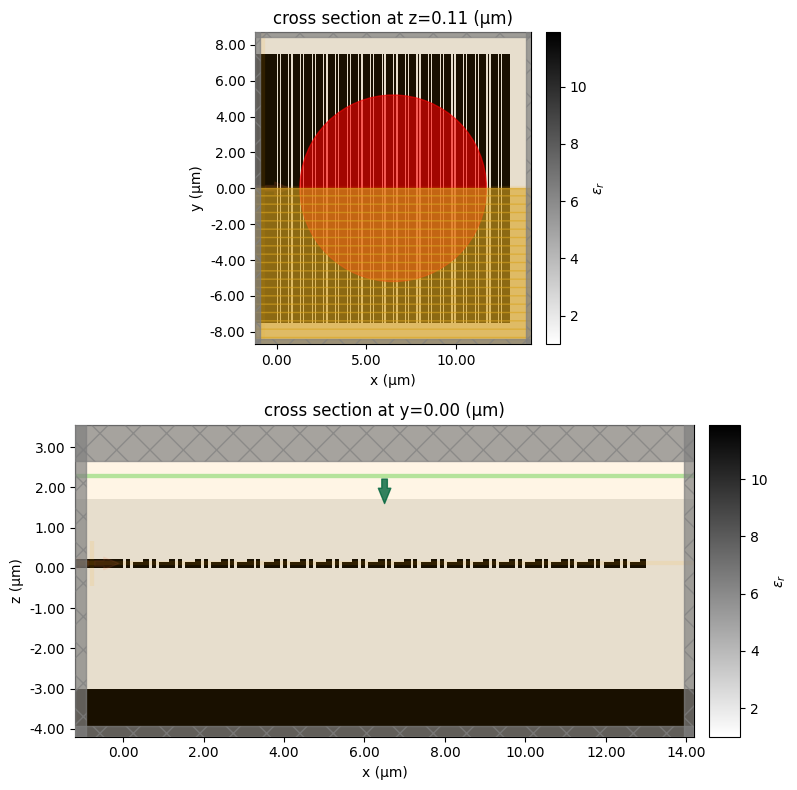

In [9]:
# Define field monitors for visualization
field_xy = td.FieldMonitor(
    center=(0, 0, h_si / 2), size=(td.inf, td.inf, 0), freqs=[freq0], name="field_xy"
)

field_xz = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, 0, td.inf), freqs=[freq0], name="field_xz"
)

# Extract optimal parameters from the results
optimal_params = results.optimizer.max["params"]

# Make a 2D simulation with the optimal parameters
sim_opt = make_sim_2d(**optimal_params)

# Update simulation with monitors and new domain size to make it 3D
sim_opt = sim_opt.updated_copy(
    size=(sim_opt.size[0], ly + 1.2 * lda0, sim_opt.size[2]),
    monitors=[sim_opt.monitors[0], field_xy, field_xz],
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    symmetry=(0, -1, 0),
)

# Plot the permittivity distribution of the optimal design
fig, ax = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True)

# Plot the permittivity distribution in the xy plane
sim_opt.plot_eps(z=h_si / 2, ax=ax[0], monitor_alpha=0.1)

# Add a circle to indicate the mode field diameter
lx = sum(optimal_params.values()) * n
circle = plt.Circle((lx / 2, 0), mfd / 2, color="red", alpha=0.6, fill=True)
ax[0].add_patch(circle)

# Plot the permittivity distribution in the xz plane
sim_opt.plot_eps(y=0, ax=ax[1], monitor_alpha=0.1)
plt.show()

Run the 3D simulation and plot the coupling efficiency spectrum.

22:55:33 Eastern Standard Time Created task 'optimal design' with task_id       
                               'fdve-feef3272-1211-48cf-a8c3-a6afe75cd1d5' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=796736;https://tidy3d.simulation.cloud/workbench?taskId=fdve-feef3272-1211-48cf-a8c3-a6afe75cd1d5\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=5277;https://tidy3d.simulation.cloud/workbench?taskId=fdve-feef3272-1211-48cf-a8c3-a6afe75cd1d5\taskId]8;;\
                               ]8;id=796736;https://tidy3d.simulation.cloud/workbench?taskId=fdve-feef3272-1211-48cf-a8c3-a6afe75cd1d5\=]8;;\]8;id=750722;https://tidy3d.simulation.cloud/workbench?taskId=fdve-feef3272-1211-48cf-a8c3-a6afe75cd1d5\fdve]8;;\]8;id=796736;https://tidy3d.simulation.cloud/workbench?taskId=fdve-feef3272-1211-48cf-a8c3-a6afe75cd1d5\-feef3272-1211-48cf-a8c3-a6afe75cd1d5']8;;\.

                               Task folder: ]8;id=401630;https://tidy3d.simulation.cloud/folders/639eb096-a602-4b56-a502-cac1f18f9557\'default']8;;\.

Output()

22:55:34 Eastern Standard Time Maximum FlexCredit cost: 3.384. Minimum cost     
                               depends on task execution details. Use           
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

22:55:35 Eastern Standard Time status = success

Output()

22:55:37 Eastern Standard Time loading simulation from simulation_data.hdf5

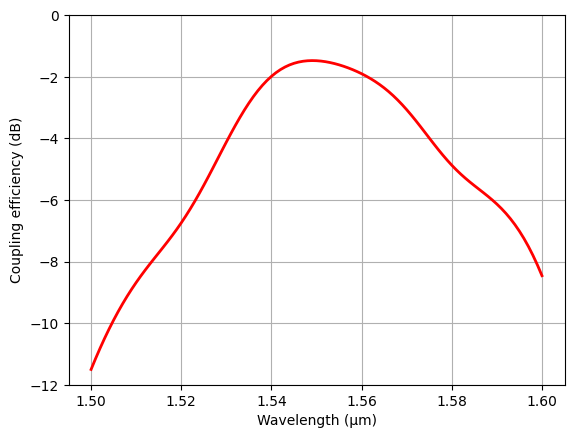

In [10]:
# Run the 3D simulation
sim_data_opt = web.run(sim_opt, "optimal design")

# extract coupling efficiency and plot it
amp = sim_data_opt["mode"].amps.sel(mode_index=0, direction="-")
T = np.abs(amp) ** 2
plt.plot(ldas, 10 * np.log10(T), c="red", linewidth=2)
plt.ylim(-12, 0)
plt.xlabel("Wavelength (μm)")
plt.ylabel("Coupling efficiency (dB)")
plt.grid()
plt.show()

Finally, plot the field distribution to visualize the mode coupling.

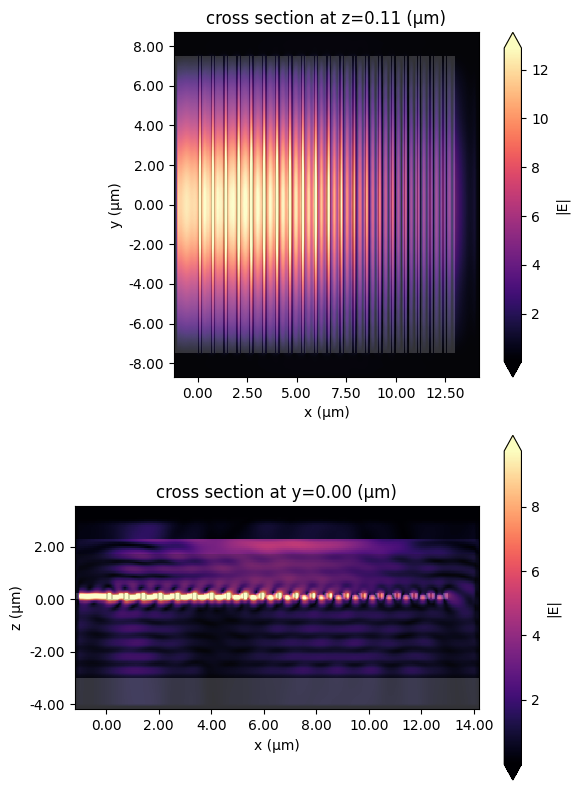

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8), tight_layout=True)
sim_data_opt.plot_field("field_xy", "E", "abs", ax=ax[0])
sim_data_opt.plot_field("field_xz", "E", "abs", ax=ax[1])
plt.show()

## Final Notes

The grating coupler is typically connected to a waveguide taper, which enables an adiabatic transition into a single-mode waveguide. In our simulation, we omit the taper to reduce computational cost. The taper itself can be optimized independently to ensure minimal loss, thereby maintaining a high overall coupling efficiency for the complete device.

In addition to Bayesian optimization, alternative optimization strategies, such as particle swarm optimization (PSO) and adjoint-based inverse design, can also be used to further improve device performance, for example through apodization.